# Variational quantum state tomography

In this notebook we will implement a variational tomographic method for pure quantum states, based on https://arxiv.org/abs/1406.4101. We start with an introduction to the problem of estimating quantum states, then we explain the method and its optimization algorithm and we finish with the implementation of the problem using pennylane. 

## Quantum state tomography

## Self guided quantum state tomography

Self guided quantum tomography works throught the maximization of the quantum fidelity $f = |\langle \phi |\psi\rangle|^2$ between the unknown state $|\psi\rangle $ of some system and one eigenvector $|\phi\rangle $ of a measurement operator, using SPSA (Simultaneous perturbation stochastic approximation). The main feature of SPSA for tomography is that it uses an aproximation of the gradient of the fidelity, instead of the exact one. This is crucial in our case, because the fidelity can be estimated experimentally, but its gradient cannot.

If $|\phi \rangle $ depends on the parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ and we are at iteration $k$, we

   (1) Generate a random direction to search given by $\boldsymbol{\Delta}_k \in \{-1, 1\}^n$.

   (2) Calculate the estimated gradient in that direction, $\boldsymbol{g}_k = \frac{f(\theta_k + \Delta_k \beta_k) - f(\theta_k - \Delta_k \beta_k) }{2 \beta_k} \boldsymbol{\Delta}_k$.

   (3) Calculate the next iterate via $\boldsymbol{\theta}_{k+1} = \boldsymbol{\theta}_{k} + \alpha_k \boldsymbol{g}_k$,

with $\alpha_k$ and $\beta_k$ functions of $k$ that control the convergence of the method. Then, in a sufficient number of iterations the estimate $|\phi (\boldsymbol{\theta}) \rangle$ is very close to the true state of the system $|\psi\rangle$, but not the same because of the shot noise of the measurements, as is usual in any tomographic method. Rambatch et al show in https://arxiv.org/pdf/2010.00632.pdf that tomography by optimization is more robust to experimental noise that tomography by estimation, which is very interesting for NISQ computation. 

## Self guided quantum state tomography using pennylane

In [1]:
import pennylane as qml    
from pennylane import numpy as np                           
import matplotlib.pyplot as plt  

We first implement SPSA. Since we use a class, it can be used like any other optimization method in pennylane.

In [2]:
class SPSA:
    
    def __init__( self, a=3 , c=0.01, A=0, α=0.602 , γ=0.101):
        self._a = a
        self._c = c
        self._A = A
        self._α = α
        self._γ = γ
        
    def step( self, function, θ, k ):
        
        ak = self._a/(k+self._A+1)**self._α, 
        ck = self._c/(k+1)**self._γ
                
        Δ  = 2*np.round( np.random.rand(θ.size).reshape(θ.shape) )-1
        
        θ_plus  = θ + ck*Δ
        θ_minus = θ - ck*Δ   
        
        function_plus  = function( θ_plus )  
        function_minus = function( θ_minus )  
        
        ghat = np.divide( function_plus-function_minus, 2*ck*Δ + 1e-8 )
        
        return θ - ak*ghat 

We set the number of qubits and the optimization algorithm. 

In [3]:
num_qubits = 5
opt = SPSA( a=2, c=0.1 )
max_iterations = 1000
np.random.seed(129464)

In [4]:
dev_an = qml.device("default.qubit", wires=num_qubits, analytic=True)
dev_st = qml.device("default.qubit", wires=num_qubits, analytic=False)

In [5]:
def GHZ_State( n_wires ):
    qml.Hadamard( wires = 0 )
    qml.broadcast( qml.CNOT, wires=range(n_wires), pattern="chain" )

### 1. Local variational form

In [6]:
def Variational_circuit(params, n_wires):
    qml.broadcast( qml.RY, wires=range(n_wires), pattern="single", parameters = params ) 

In [7]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [8]:
infids_an = []
infids_st = []
params    = .25*np.ones(num_qubits)
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'Final fidelidad = ', 1-infids_an[-1] )
print()

infids_an = np.array(infids_an)
infids_st = np.array(infids_st)


Final fidelidad =  0.4976544894933157



Text(0, 0.5, 'Infidelity')

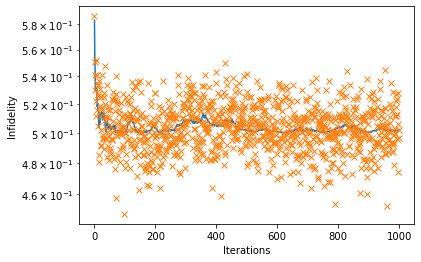

In [9]:
plt.plot( infids_an )
plt.yscale('log')
ylim = min( 0.01, plt.axis()[2] )
infids_st[infids_st<ylim] = ylim
plt.plot( infids_st , 'x')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')

### 2. MPS variational form

In [10]:
@qml.template
def single_layer( parameters, wires ):
    qml.RY( parameters[0], wires = wires[0] )
    qml.CNOT( wires = wires)
    qml.RY( parameters[1], wires = wires[0] )
    qml.RY( parameters[2], wires = wires[1] )

@qml.template
def Variational_circuit(params, n_wires):
    qml.RY( params[0], wires = n_wires-1 )
    params = params[:-1].reshape(n_wires-1,3)
    for k in reversed(range(n_wires-1)) :
        single_layer( params[k] , [k,k+1] )

In [11]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [12]:
infids_an = []
infids_st = []
params    = .25*np.ones(3*num_qubits-2)
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'Final fidelidad = ', 1-infids_an[-1] )
print()

infids_an = np.array(infids_an)
infids_st = np.array(infids_st)


Final fidelidad =  0.9997434642954134



Text(0, 0.5, 'Infidelity')

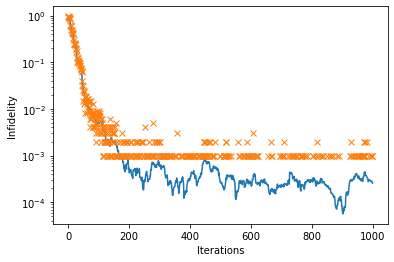

In [13]:
plt.plot( infids_an )
plt.plot( infids_st , 'x')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')

### 3. Dense variational form

In [14]:
def single_layer(W):
    n_wires  = W.shape[0]
    qml.broadcast( qml.RY, wires=range(n_wires), pattern="single", parameters = W ) 
    qml.broadcast( qml.CNOT, wires=range(n_wires), pattern="all_to_all" )

def Variational_circuit(params, wires):
    n_layers = params.shape[0]-1
    n_wires = params.shape[1]
    qml.layer( single_layer, n_layers, params[:n_layers] )
    qml.broadcast( qml.RY, wires=range(n_wires), pattern="single", parameters = params[n_layers] ) 


In [15]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State( n_wires )
    Variational_circuit(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [16]:
infids_an = []
infids_st = []
num_layers= num_qubits
params    = np.zeros((num_layers,num_qubits))
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'Final fidelidad = ', 1-infids_an[-1] )
print()

infids_an = np.array(infids_an)
infids_st = np.array(infids_st)


Final fidelidad =  0.9992443844511494



Text(0, 0.5, 'Infidelity')

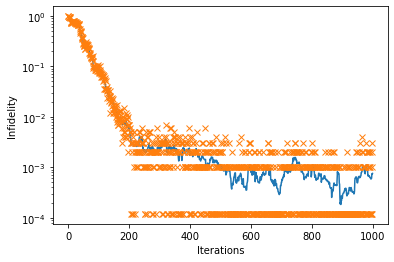

In [17]:
plt.plot( infids_an )
plt.yscale('log')
ylim = plt.axis()[2]
infids_st[infids_st<ylim] = ylim
plt.plot( infids_st , 'x')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')